In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import sweetviz
import ast

#sql
import pandas.io.sql as sqlio
import psycopg2

### 1. Import data

#### 1.1. Doc_reports

In [2]:
doc_reports = pd.read_csv("./kyc_data/doc_reports.csv")
doc_reports = doc_reports.iloc[:, 1:]

#convert "created_at" to date format
doc_reports['created_at'] = doc_reports['created_at'].apply(lambda x: str(x)[:10])
doc_reports['created_at'] = pd.to_datetime(doc_reports['created_at'].values, format= "%Y-%m-%d")
print("Min created_at:", min(doc_reports['created_at']), '\nMax created_at:', max(doc_reports['created_at']))

Min created_at: 2017-05-23 00:00:00 
Max created_at: 2017-10-31 00:00:00


In [3]:
#null stats
print("Number of rows: ", len(doc_reports))
doc_reports.isnull().sum()

Number of rows:  176404


user_id                                    0
result                                     0
visual_authenticity_result             26114
image_integrity_result                     1
face_detection_result                  26143
image_quality_result                       1
created_at                                 0
supported_document_result                504
conclusive_document_quality_result     81187
colour_picture_result                  81182
data_validation_result                 33430
data_consistency_result                84175
data_comparison_result                173856
attempt_id                                 0
police_record_result                   31847
compromised_document_result           130898
properties                                 0
sub_result                                 0
dtype: int64

#### 1.2. facial_similarity_reports

In [4]:
facial_similarity_reports = pd.read_csv("./kyc_data/facial_similarity_reports.csv")
#convert "created_at" to date format
facial_similarity_reports['created_at'] = facial_similarity_reports['created_at'].apply(lambda x: str(x)[:10])
facial_similarity_reports['created_at'] = pd.to_datetime(facial_similarity_reports['created_at'].values, format= "%Y-%m-%d")
print("Min created_at:", min(facial_similarity_reports['created_at']), '\nMax created_at:', max(facial_similarity_reports['created_at']))

Min created_at: 2017-05-23 00:00:00 
Max created_at: 2017-10-31 00:00:00


In [5]:
#null stats
print("Number of rows: ", len(facial_similarity_reports))
facial_similarity_reports.isnull().sum()

Number of rows:  176404


Unnamed: 0                           0
user_id                              0
result                               1
face_comparison_result           10397
created_at                           0
facial_image_integrity_result      463
visual_authenticity_result       26114
properties                           0
attempt_id                           0
dtype: int64

> Let's consider the document verification pipeline, which consists of two stages:Document check and Facial Similarity check
<br>The key indicator will be the <b>"pass score"</b> for each stage. This metric is defined as the number of customers who have passed the required stage, divided by the number of customers who will try to pass this stage

### 2. Analysis of both stages

#### 2.1 Document check

In [6]:
def rate_dynamic_in_time(data, metric_name, group_name):
    #group stats
    stage_stat = data.groupby([group_name, 'created_at'], as_index=False)[['attempt_id']].count()
    stage_stat = stage_stat.rename({"attempt_id":"stage_attempt_num"}, axis=1)

    #all cases stats
    stage_stat_all = data.groupby(['created_at'], as_index=False)[['attempt_id']].count()
    stage_stat_all = stage_stat_all.rename({"attempt_id":"all_attempt_num"}, axis=1)

    #final table
    stage_stat = stage_stat.merge(stage_stat_all)
    stage_stat[metric_name] = stage_stat['stage_attempt_num'] / stage_stat['all_attempt_num']
    
    return stage_stat.sort_values('created_at')

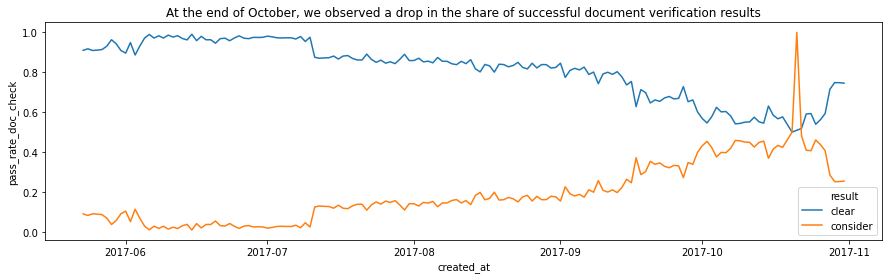

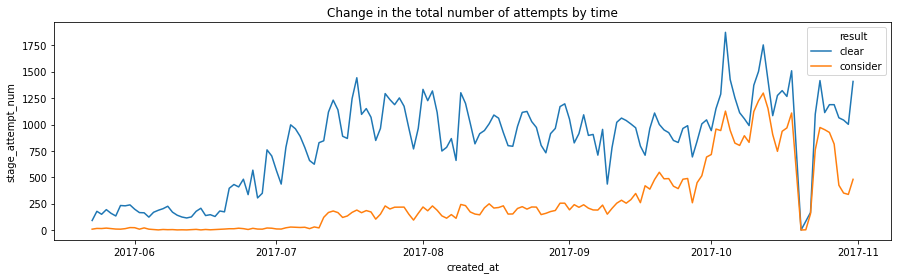

In [7]:
group_name = 'result'
metric_name = 'pass_rate_doc_check'
data = doc_reports
current_stats = rate_dynamic_in_time(data, metric_name, group_name)  

#visualization
f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y=metric_name, hue=group_name, data=current_stats)\
    .set_title('At the end of October, we observed a drop in the share of successful document verification results')
plt.show()

f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y='stage_attempt_num', hue=group_name, data=current_stats)\
    .set_title('Change in the total number of attempts by time')
plt.show()

#### 2.2 Facial Similarity

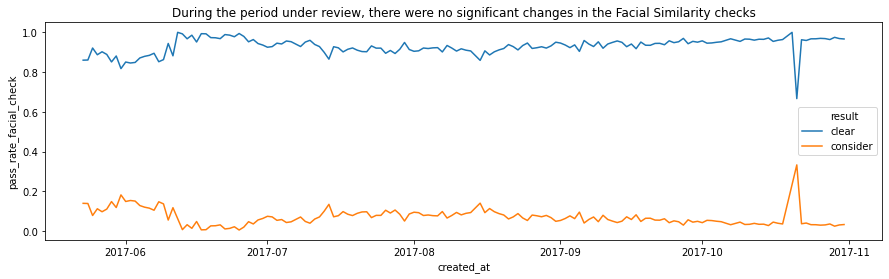

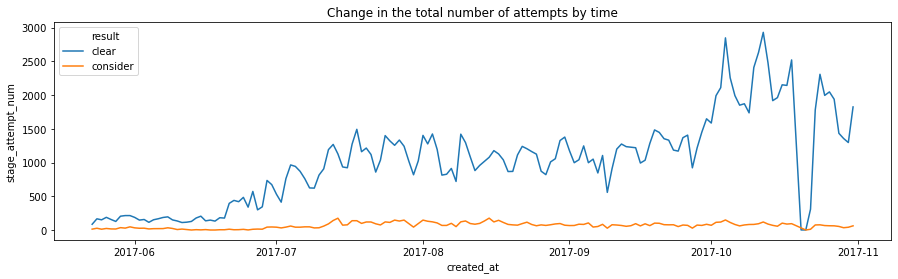

In [8]:
group_name = 'result'
metric_name = 'pass_rate_facial_check'
data = facial_similarity_reports
current_stats = rate_dynamic_in_time(data, metric_name, group_name)  

#visualization
f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y=metric_name, hue=group_name, data=current_stats)\
    .set_title('During the period under review, there were no significant changes in the Facial Similarity checks')
plt.show()

f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y='stage_attempt_num', hue=group_name, data=current_stats)\
    .set_title('Change in the total number of attempts by time')
plt.show()

>At this stage, we should focus on the document verification stage, because this is the main cause of the problem

### 3.  Segmentation of the results of document verification stage. Splitting by sub_result

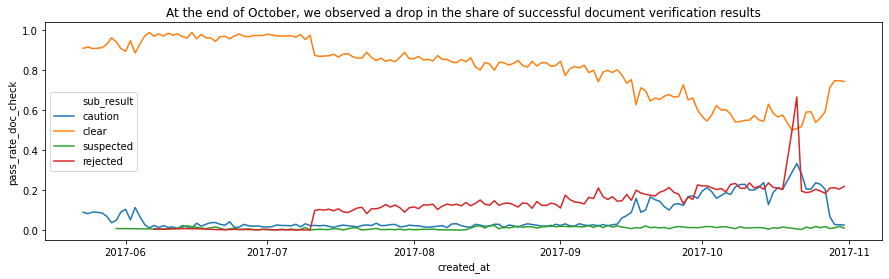

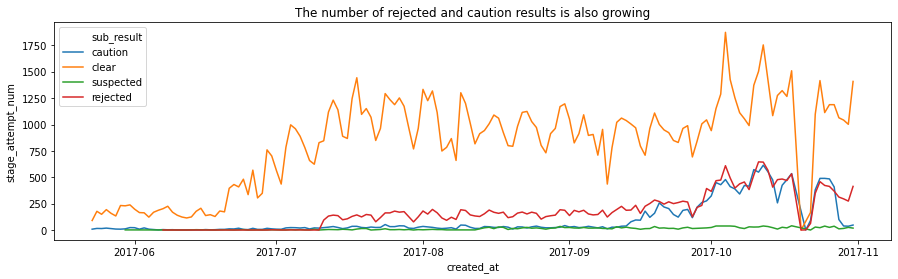

In [9]:
group_name = 'sub_result'
metric_name = 'pass_rate_doc_check'
data = doc_reports
current_stats = rate_dynamic_in_time(data, metric_name, group_name)  

#visualization
f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y=metric_name, hue=group_name, data=current_stats)\
    .set_title('At the end of October, we observed a drop in the share of successful document verification results')
plt.show()


#visualization
f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y='stage_attempt_num', hue=group_name, data=current_stats)\
    .set_title('The number of rejected and caution results is also growing')
plt.show()

>At this stage, we should focus on caution and rejected results, because they are the main cause of the problem
<br>
- rejected	If the report has returned information where the check cannot be processed further (poor quality image or an unsupported document).
- caution	If any other underlying verifications fail but they don’t necessarily point to a fraudulent document (such as the name provided by the applicant doesn’t match the one on the document)

### 4.  Segmentation of the subresults. Splitting by document type

In [10]:
doc_reports_details = doc_reports.copy()
doc_reports_details['properties'] = doc_reports_details['properties'].apply(lambda x: ast.literal_eval(x))
doc_reports_details['document_type'] = doc_reports_details['properties']\
        .apply(lambda x: x['document_type'] if "document_type" in x.keys() else 'None')

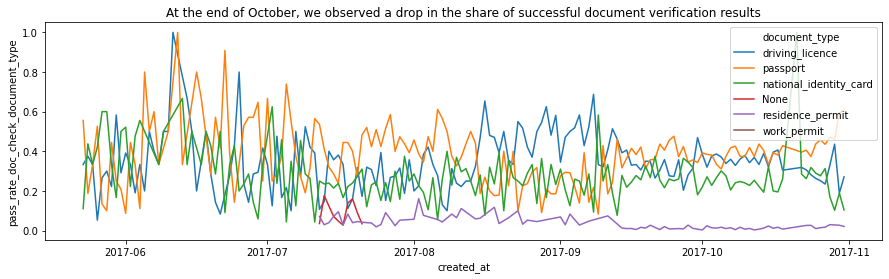

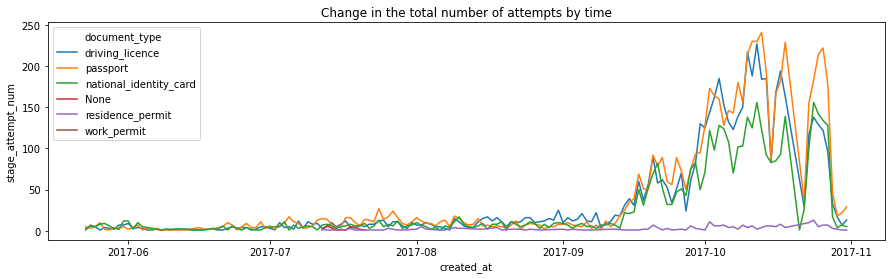

In [11]:
#segmentation  caution results by document type

group_name = 'document_type'
metric_name = 'pass_rate_doc_check_document_type'
data = doc_reports_details[doc_reports_details['sub_result'] == "caution"]
current_stats = rate_dynamic_in_time(data, metric_name, group_name)  

#visualization
f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y=metric_name, hue=group_name, data=current_stats)\
    .set_title('At the end of October, we observed a drop in the share of successful document verification results')
plt.show()


f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y='stage_attempt_num', hue=group_name, data=current_stats)\
    .set_title('Change in the total number of attempts by time')
plt.show()

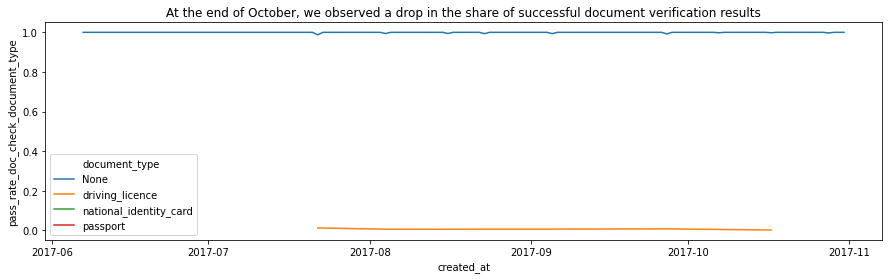

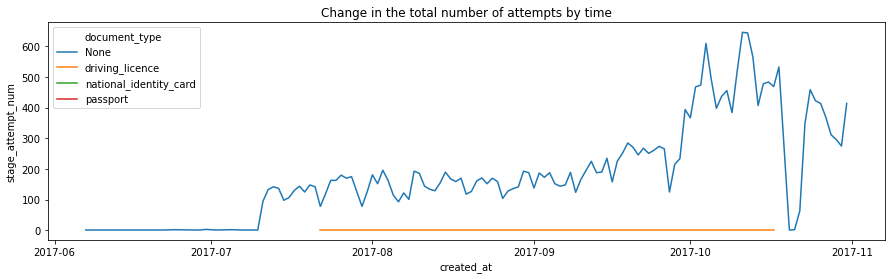

In [12]:
#segmentation rejected results by document type
group_name = 'document_type'
metric_name = 'pass_rate_doc_check_document_type'
data = doc_reports_details[doc_reports_details['sub_result'] == "rejected"]
current_stats = rate_dynamic_in_time(data, metric_name, group_name)  

#visualization
f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y=metric_name, hue=group_name, data=current_stats)\
    .set_title('At the end of October, we observed a drop in the share of successful document verification results')
plt.show()


f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x='created_at', y='stage_attempt_num', hue=group_name, data=current_stats)\
    .set_title('Change in the total number of attempts by time')
plt.show()

>We can assume that the rejected results were caused by empty document type values in API requests

### 5.  Analysis of the indicators of the caution results and rejected results <br>

>Finally, let's prioritize the possible causes of caution results and rejected results.

#### 5.1 all requests for document verification

#### 5.1 rejected requests<br>
- rejected	If the report has returned information where the check cannot be processed further (poor quality image or an unsupported document).

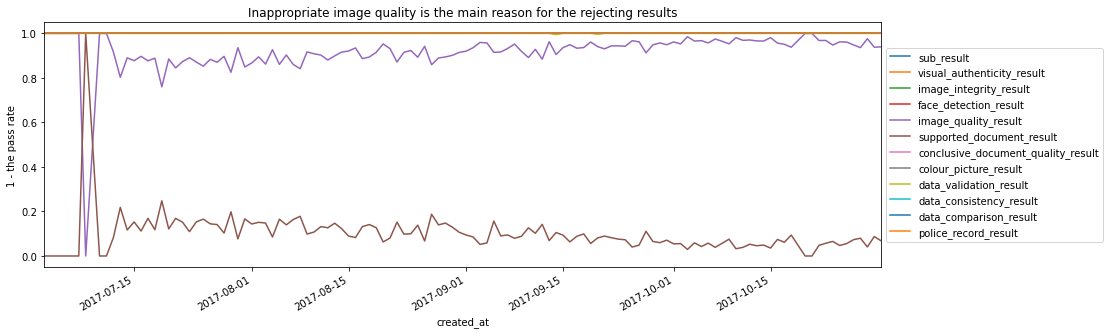

In [13]:
#Let's prioritize the potential reasons for rejected requests

need_columns = ['created_at', 'sub_result',
       'visual_authenticity_result',
       'image_integrity_result', 'face_detection_result',
       'image_quality_result', 'supported_document_result',
       'conclusive_document_quality_result', 'colour_picture_result',
       'data_validation_result', 'data_consistency_result',
       'data_comparison_result', 'police_record_result']
#find pass rates for several types of results
doc_reports_drivers = doc_reports[need_columns].copy()
doc_reports_drivers = doc_reports_drivers[doc_reports_drivers['sub_result'] == 'rejected']

#find the failure rate of these requests (result != 'clear')
for col in need_columns[1:]:
    doc_reports_drivers[col] = doc_reports_drivers[col].apply(lambda x: 1 if x != 'clear' else 0)
doc_reports_drivers['attemps_num'] = 1
doc_reports_drivers_stat = doc_reports_drivers.groupby(['created_at'], as_index=False).sum()
for col in need_columns[1:]:
    doc_reports_drivers_stat[col] = doc_reports_drivers_stat[col] / doc_reports_drivers_stat['attemps_num']

#visualization
ax = doc_reports_drivers_stat[doc_reports_drivers_stat['created_at'] > '2017-07-01' ]\
                    .set_index('created_at').drop(columns=['attemps_num']).plot(figsize=(15, 5));
ax.set_ylabel("1 - the pass rate")
ax.set_title("Inappropriate image quality is the main reason for the rejecting results")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

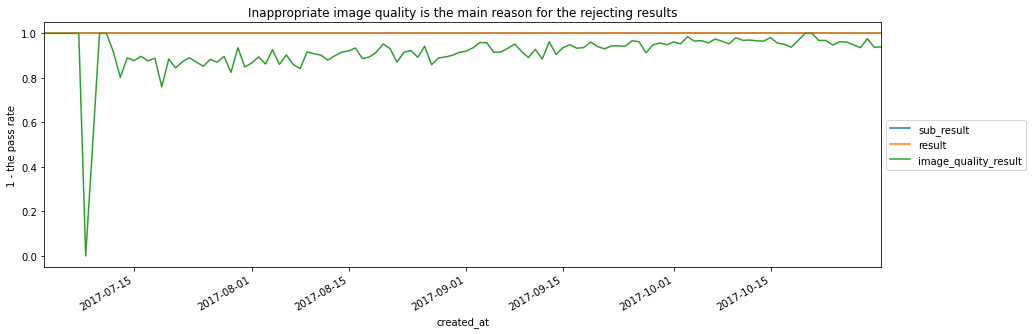

In [14]:
#Let's consider only the relevant quality check

need_columns = ['created_at', 'sub_result', 'result','image_quality_result']
#find pass rates for several types of results
doc_reports_drivers = doc_reports[need_columns].copy()
doc_reports_drivers = doc_reports_drivers[doc_reports_drivers['sub_result'] == 'rejected']

#find the failure rate of these requests (result != 'clear')
for col in need_columns[1:]:
    doc_reports_drivers[col] = doc_reports_drivers[col].apply(lambda x: 1 if x != 'clear' else 0)
doc_reports_drivers['attemps_num'] = 1
doc_reports_drivers_stat = doc_reports_drivers.groupby(['created_at'], as_index=False).sum()
for col in need_columns[1:]:
    doc_reports_drivers_stat[col] = doc_reports_drivers_stat[col] / doc_reports_drivers_stat['attemps_num']

#visualization
ax = doc_reports_drivers_stat[doc_reports_drivers_stat['created_at'] > '2017-07-01' ]\
                    .set_index('created_at').drop(columns=['attemps_num']).plot(figsize=(15, 5));
ax.set_ylabel("1 - the pass rate")
ax.set_title("Inappropriate image quality is the main reason for the rejecting results")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

>Inappropriate image quality is the main reason for the rejecting results (see the sub_result column)

#### 5.2 caution requests <br>
- caution	If any other underlying verifications fail but they don’t necessarily point to a fraudulent document (such as the name provided by the applicant doesn’t match the one on the document)

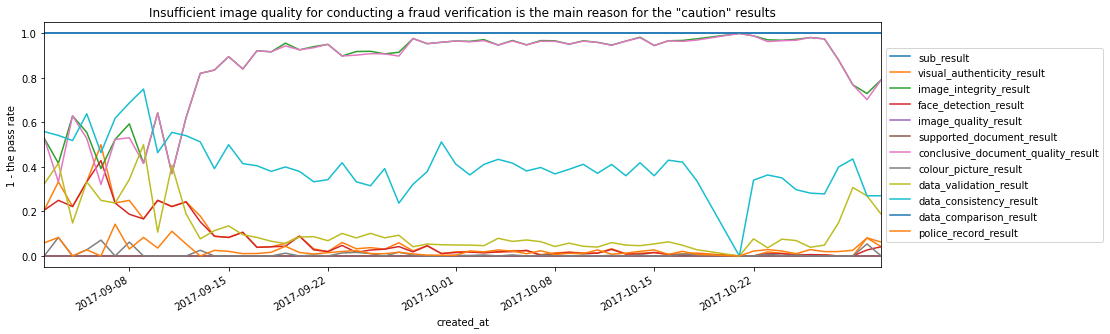

In [15]:
#Let's prioritize the potential reasons for caution requests

need_columns = ['created_at', 'sub_result',
       'visual_authenticity_result',
       'image_integrity_result', 'face_detection_result',
       'image_quality_result', 'supported_document_result',
       'conclusive_document_quality_result', 'colour_picture_result',
       'data_validation_result', 'data_consistency_result',
       'data_comparison_result', 'police_record_result']

#find pass rates for several types of results
doc_reports_drivers = doc_reports[need_columns].copy()
doc_reports_drivers = doc_reports_drivers[doc_reports_drivers['sub_result'] == 'caution']

#find the failure rate of these requests (result != 'clear')
for col in need_columns[1:]:
    doc_reports_drivers[col] = doc_reports_drivers[col].apply(lambda x: 1 if x != 'clear' else 0)
doc_reports_drivers['attemps_num'] = 1
doc_reports_drivers_stat = doc_reports_drivers.groupby(['created_at'], as_index=False).sum()
for col in need_columns[1:]:
    doc_reports_drivers_stat[col] = doc_reports_drivers_stat[col] / doc_reports_drivers_stat['attemps_num']

#visualization
ax = doc_reports_drivers_stat[doc_reports_drivers_stat['created_at'] > '2017-09-01' ]\
                    .set_index('created_at').drop(columns=['attemps_num']).plot(figsize=(15, 5));
ax.set_title("Insufficient image quality for conducting a fraud verification is the main reason for the \"caution\" results")
ax.set_ylabel("1 - the pass rate")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

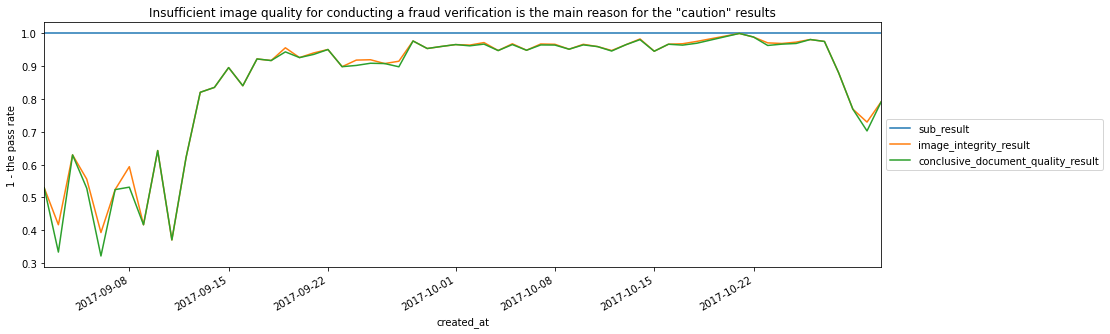

In [16]:
#Let's consider only the relevant quality check

need_columns = ['created_at', 'sub_result',
       'image_integrity_result','conclusive_document_quality_result']

#find pass rates for several types of results
doc_reports_drivers = doc_reports[need_columns].copy()
doc_reports_drivers = doc_reports_drivers[doc_reports_drivers['sub_result'] == 'caution']

#find the failure rate of these requests (result != 'clear')
for col in need_columns[1:]:
    doc_reports_drivers[col] = doc_reports_drivers[col].apply(lambda x: 1 if x != 'clear' else 0)
doc_reports_drivers['attemps_num'] = 1
doc_reports_drivers_stat = doc_reports_drivers.groupby(['created_at'], as_index=False).sum()
for col in need_columns[1:]:
    doc_reports_drivers_stat[col] = doc_reports_drivers_stat[col] / doc_reports_drivers_stat['attemps_num']

#visualization
ax = doc_reports_drivers_stat[doc_reports_drivers_stat['created_at'] > '2017-09-01' ]\
                    .set_index('created_at').drop(columns=['attemps_num']).plot(figsize=(15, 5));
ax.set_title("Insufficient image quality for conducting a fraud verification is the main reason for the \"caution\" results")
ax.set_ylabel("1 - the pass rate")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

>The pass rate of <b> "conclusive document quality" check ("image_integrity_result" check) </b> is the main reason for the "caution" results (see the sub_result column)